In [32]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import gower
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from tqdm import tqdm

In [33]:
df = pd.read_csv('/home/jupyter/clusters.csv').drop('Unnamed: 0', axis=1)
cluster = df[df.cluster==0]
print(cluster.shape)
cluster.head()

(13155, 26)


,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,track_id,artist_id
15,['The Byrds'],You Ain't Going Nowhere,0.1090,0.547,155000,0.342,0,0.003580,7,0.4080,-19.220,1,27,0.0431,130.846,0.626,1971-10-29,1971,0.171422,0.254083,0.263735,0.183618,0,"['art rock', 'beatlesque', 'blues rock', 'bril...",6I9Xt4AlsHnW5YGjbtBinf,1PCZpxHJz7WAMF8EEq8bfc
23,['Michael Jackson'],You've Got A Friend,0.5010,0.543,298960,0.635,0,0.000001,0,0.0955,-8.967,1,27,0.0351,168.399,0.810,1972-01-24,1972,0.085991,0.231792,0.255862,0.092941,0,"['pop', 'r&b', 'soul']",1jrJQ1Gib2ubaxAXe1z2Jc,3fMbdgg4jU18AjLCKBhRSm
26,['Johnny Nash'],STIR IT UP,0.2090,0.671,182707,0.567,0,0.006480,2,0.1390,-6.514,1,29,0.0386,85.358,0.902,1972,1972,0.157838,0.211890,0.236735,0.185827,0,"['brill building pop', 'bubblegum pop', 'class...",3BT7TYH4vYIOYNrVDxnDuv,0nAVvgfE9yI4DwvMiYwk8a
31,"['Nancy Sinatra', 'Lee Hazlewood']",Big Red Balloon,0.1360,0.495,257827,0.856,0,0.000038,2,0.0748,-8.018,1,34,0.0596,114.818,0.619,1972-01-01,1972,0.106259,0.195449,0.216339,0.185808,0,"['adult standards', 'brill building pop', 'fol...",5vFehufd1f9OnKY8WJOLy0,3IZrrNonYELubLPJmqOci2
33,['Big Star'],My Life Is Right,0.0212,0.223,186867,0.606,0,0.000087,2,0.2480,-8.002,1,26,0.0300,86.163,0.386,1972,1972,0.173663,0.251167,0.261166,0.197326,0,"['alternative rock', 'art rock', 'baroque pop'...",2P6csHYB1f4PL3Wvm7tFqa,3UvcmAOZt64oKpP95f6MMM


# Preprocessing #

In [34]:
# create new data frame with only necessary features for modeling
model = cluster.drop(['artists', 'name', 'popularity', 'release_date', 'year', 'medoid_0', 'medoid_1', 'medoid_2', 
                      'medoid_3', 'cluster', 'genre', 'artist_id'], axis=1)
model.set_index('track_id', inplace=True)
print(model.shape)
model.head()

(13155, 13)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
track_id,,,,,,,,,,,,,
6I9Xt4AlsHnW5YGjbtBinf,0.1090,0.547,155000,0.342,0,0.003580,7,0.4080,-19.220,1,0.0431,130.846,0.626
1jrJQ1Gib2ubaxAXe1z2Jc,0.5010,0.543,298960,0.635,0,0.000001,0,0.0955,-8.967,1,0.0351,168.399,0.810
3BT7TYH4vYIOYNrVDxnDuv,0.2090,0.671,182707,0.567,0,0.006480,2,0.1390,-6.514,1,0.0386,85.358,0.902
5vFehufd1f9OnKY8WJOLy0,0.1360,0.495,257827,0.856,0,0.000038,2,0.0748,-8.018,1,0.0596,114.818,0.619
2P6csHYB1f4PL3Wvm7tFqa,0.0212,0.223,186867,0.606,0,0.000087,2,0.2480,-8.002,1,0.0300,86.163,0.386


In [35]:
# create list for different types of features for access later
num_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
                'speechiness', 'tempo', 'valence']
cat_features = ['explicit', 'mode', 'key']

### Calculate Matrix of Similarities Between All Tracks ###

In [36]:
# create a list of cat_features indicators
cat_ind = [True if x in cat_features else False for x in model.columns]

gdf = gower.gower_matrix(model, cat_features=cat_ind)

In [37]:
gdf_model = pd.DataFrame(gdf, index=model.index)
print(gdf_model.shape)
gdf_model.head()

(13155, 13155)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,13130,13131,13132,13133,13134,13135,13136,13137,13138,13139,13140,13141,13142,13143,13144,13145,13146,13147,13148,13149,13150,13151,13152,13153,13154
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6I9Xt4AlsHnW5YGjbtBinf,0.000000,0.158193,0.131522,0.122905,0.145634,0.104391,0.101176,0.123272,0.014638,0.108615,0.092134,0.162758,0.108643,0.100824,0.168625,0.123614,0.106099,0.135109,0.125451,0.169319,0.147529,0.118648,0.143068,0.149921,0.137142,...,0.074413,0.125495,0.118801,0.090813,0.131637,0.131559,0.120638,0.131326,0.105094,0.140236,0.153271,0.103127,0.139681,0.147230,0.124984,0.112423,0.131975,0.145532,0.181878,0.150185,0.096518,0.112561,0.108760,0.205094,0.122264
1jrJQ1Gib2ubaxAXe1z2Jc,0.158193,0.000000,0.162992,0.170428,0.231250,0.171284,0.218719,0.191295,0.174328,0.169128,0.144934,0.144330,0.150508,0.169095,0.198383,0.158020,0.072875,0.224971,0.142268,0.103505,0.126115,0.105056,0.143223,0.098512,0.212380,...,0.179517,0.122617,0.145691,0.174514,0.165722,0.183037,0.153066,0.141352,0.173975,0.159389,0.209581,0.179130,0.178167,0.189615,0.102847,0.181573,0.183695,0.195232,0.208075,0.162805,0.158100,0.166271,0.142424,0.160701,0.179772
3BT7TYH4vYIOYNrVDxnDuv,0.131522,0.162992,0.000000,0.085588,0.102670,0.089157,0.217731,0.146815,0.188595,0.194364,0.160570,0.172222,0.128112,0.148510,0.200862,0.166129,0.125225,0.233946,0.174842,0.225646,0.140473,0.191139,0.106350,0.202577,0.108120,...,0.127248,0.053916,0.112929,0.160146,0.200032,0.136357,0.132688,0.191087,0.167765,0.201881,0.178791,0.131060,0.037633,0.160828,0.174939,0.159914,0.145684,0.158500,0.241748,0.123631,0.179098,0.142639,0.178611,0.217142,0.082973
5vFehufd1f9OnKY8WJOLy0,0.122905,0.170428,0.085588,0.000000,0.104025,0.042598,0.171393,0.132483,0.124085,0.125012,0.133701,0.163954,0.125355,0.147520,0.144841,0.112290,0.111528,0.150936,0.156952,0.190098,0.153858,0.147687,0.146389,0.169258,0.079823,...,0.131090,0.053779,0.124674,0.141075,0.120880,0.166070,0.125953,0.171533,0.145252,0.122902,0.151378,0.131999,0.071622,0.145734,0.106022,0.115822,0.116782,0.154976,0.197254,0.128660,0.154333,0.112854,0.134542,0.226750,0.055615
2P6csHYB1f4PL3Wvm7tFqa,0.145634,0.231250,0.102670,0.104025,0.000000,0.112555,0.160327,0.134573,0.194721,0.182209,0.186567,0.214277,0.140423,0.152791,0.146504,0.186459,0.157602,0.153477,0.213641,0.241994,0.199487,0.169498,0.193041,0.150487,0.134448,...,0.179125,0.131314,0.162127,0.184358,0.159436,0.184066,0.178321,0.155908,0.149110,0.198777,0.129599,0.156137,0.098800,0.172544,0.160482,0.155497,0.128441,0.123078,0.231049,0.198056,0.155286,0.186564,0.168957,0.282995,0.079528


# Modeling #

In [161]:
np.random.seed(5146)

# find k clusters
results_kmedoids1 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 13155,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids1[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [08:44<00:00, 104.99s/it]


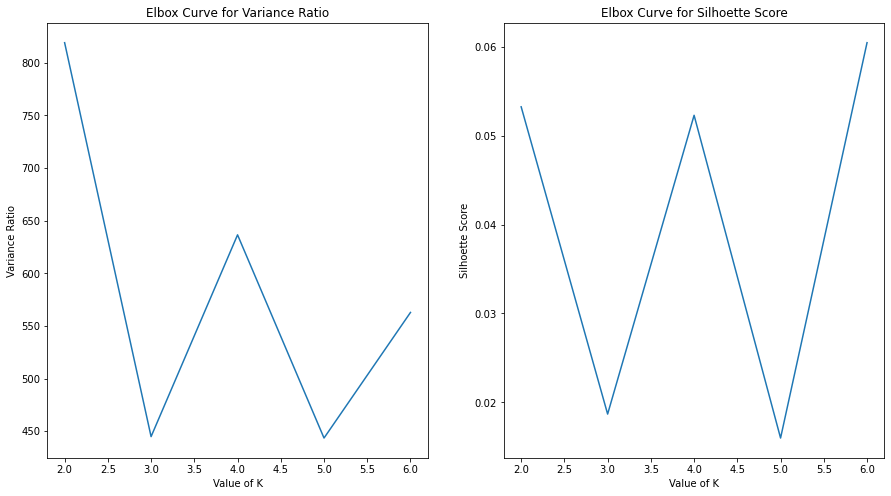

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids1.keys()],[i['v_ratio'] for i in results_kmedoids1.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids1.keys()],[i['s_score'] for i in results_kmedoids1.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all={}
results_all['model1'] = results_kmedoids1

In [ ]:
np.random.seed(4192)

# find k clusters
results_kmedoids2 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids2[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [08:40<00:00, 104.00s/it]


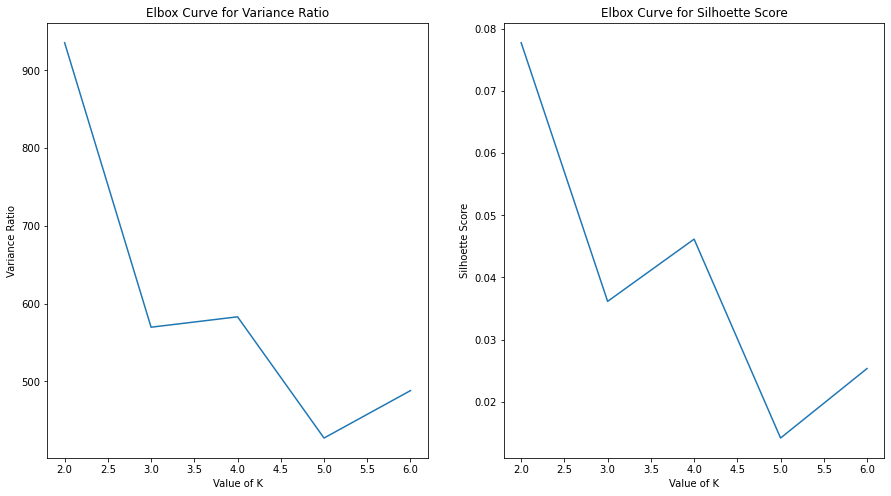

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids2.keys()],[i['v_ratio'] for i in results_kmedoids2.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids2.keys()],[i['s_score'] for i in results_kmedoids2.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all['model2'] = results_kmedoids2

In [188]:
np.random.seed(2006)

# find k clusters
results_kmedoids3 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids3[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [08:52<00:00, 106.51s/it]


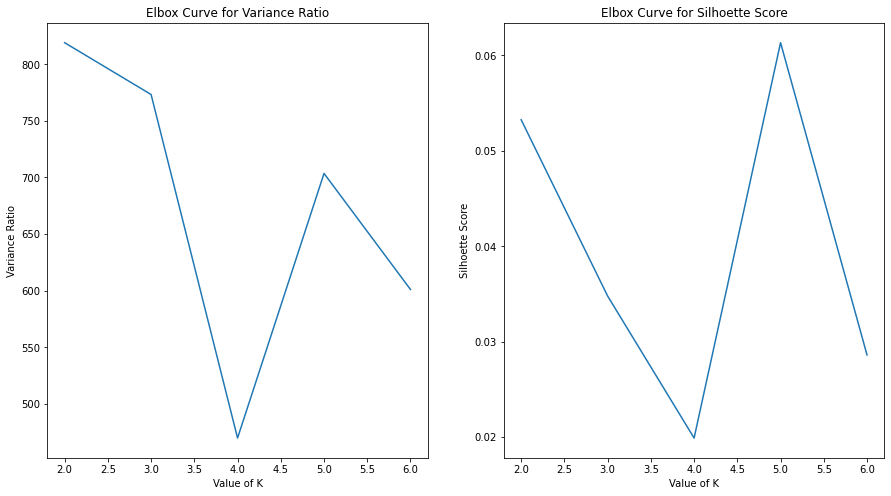

In [189]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids3.keys()],[i['v_ratio'] for i in results_kmedoids3.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids3.keys()],[i['s_score'] for i in results_kmedoids3.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [190]:
# save results for later and use in analysis notebook
results_all['model3'] = results_kmedoids3

In [ ]:
np.random.seed(3326)

# find k clusters
results_kmedoids4 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids4[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [08:43<00:00, 104.70s/it]


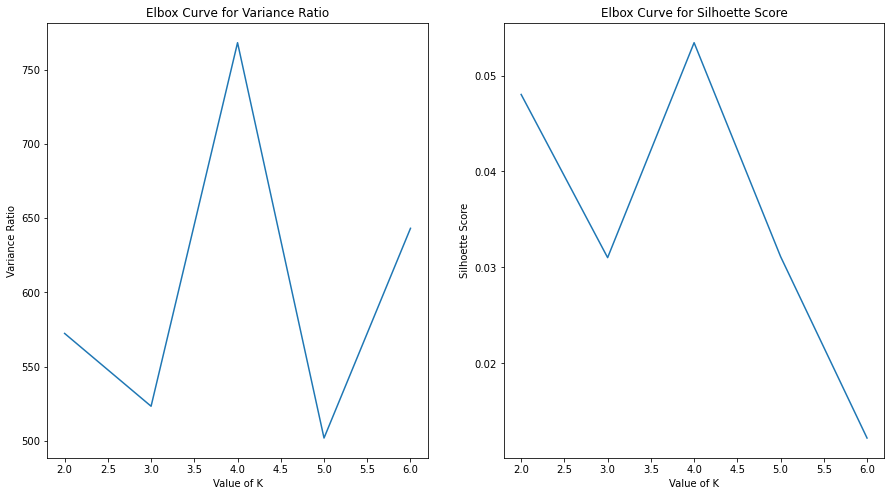

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids4.keys()],[i['v_ratio'] for i in results_kmedoids4.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids4.keys()],[i['s_score'] for i in results_kmedoids4.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all['model4'] = results_kmedoids4

In [ ]:
np.random.seed(4533)

# find k clusters
results_kmedoids5 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids5[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [09:03<00:00, 108.79s/it]


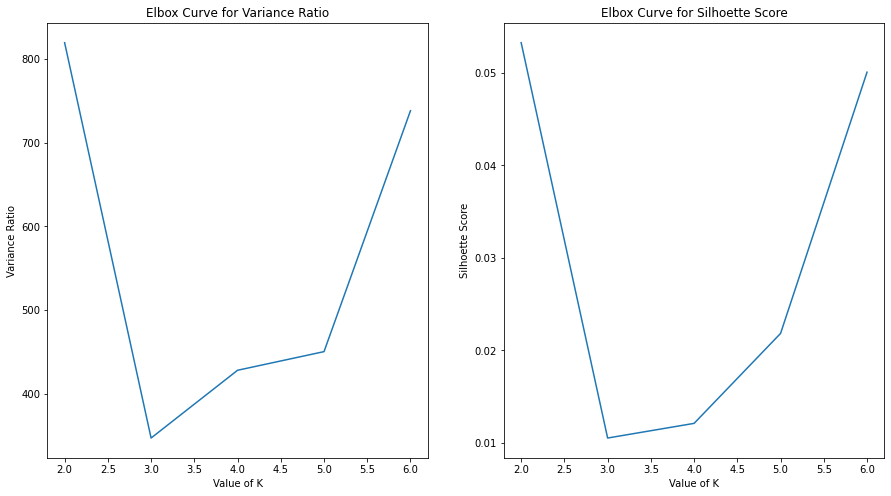

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids5.keys()],[i['v_ratio'] for i in results_kmedoids5.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids5.keys()],[i['s_score'] for i in results_kmedoids5.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all['model5'] = results_kmedoids5

In [ ]:
np.random.seed(2438)

# find k clusters
results_kmedoids6 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids6[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [09:14<00:00, 110.93s/it]


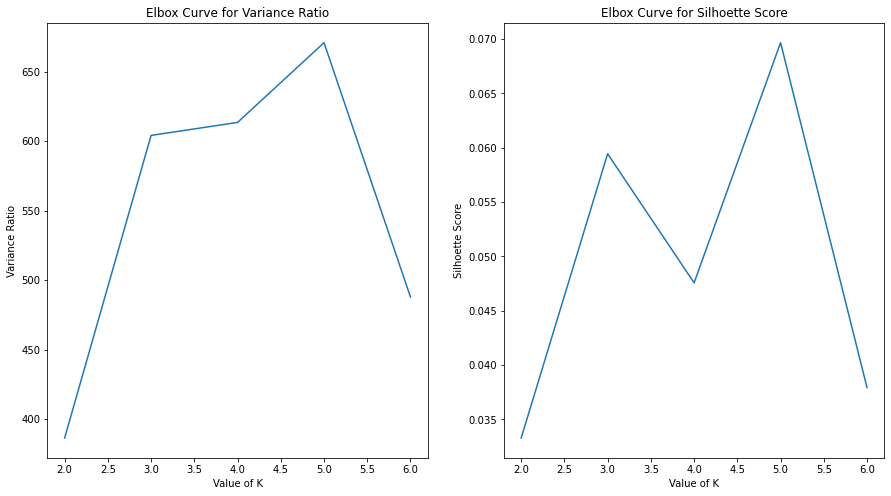

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids6.keys()],[i['v_ratio'] for i in results_kmedoids6.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids6.keys()],[i['s_score'] for i in results_kmedoids6.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all['model6'] = results_kmedoids6

In [ ]:
np.random.seed(309)

# find k clusters
results_kmedoids7 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids7[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [08:57<00:00, 107.42s/it]


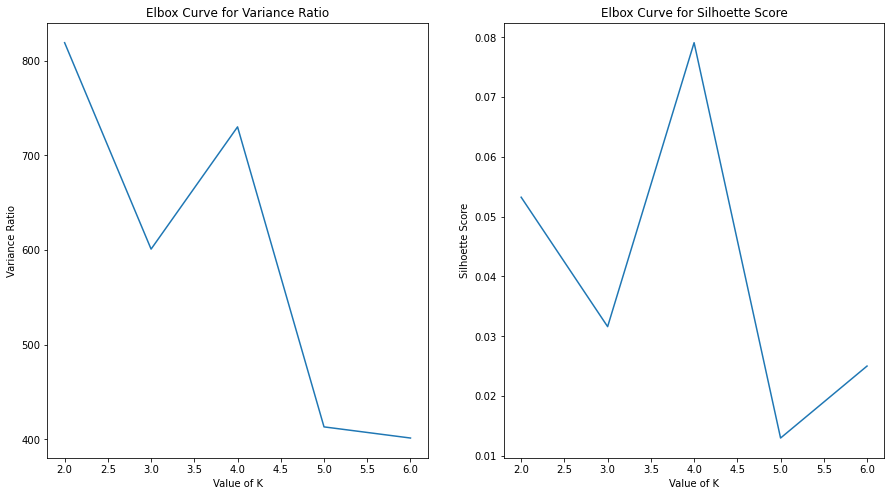

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids7.keys()],[i['v_ratio'] for i in results_kmedoids7.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids7.keys()],[i['s_score'] for i in results_kmedoids7.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all['model7'] = results_kmedoids7

In [ ]:
np.random.seed(1015)

# find k clusters
results_kmedoids8 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids8[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [08:51<00:00, 106.29s/it]


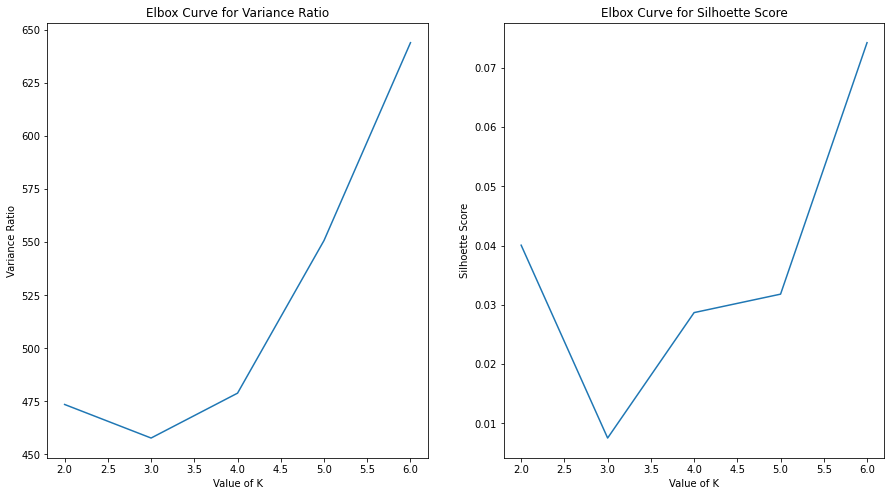

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids8.keys()],[i['v_ratio'] for i in results_kmedoids8.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids8.keys()],[i['s_score'] for i in results_kmedoids8.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all['model8'] = results_kmedoids8

In [ ]:
np.random.seed(1254)

# find k clusters
results_kmedoids9 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids9[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [08:59<00:00, 107.99s/it]


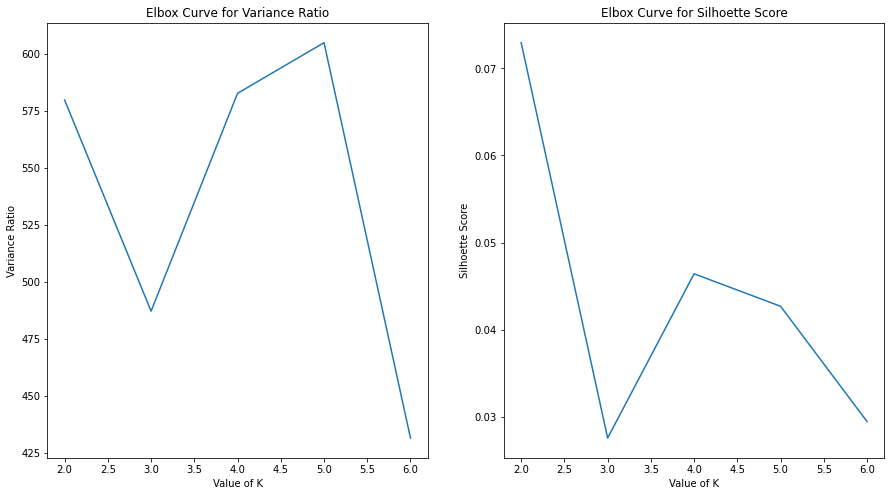

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids9.keys()],[i['v_ratio'] for i in results_kmedoids9.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids9.keys()],[i['s_score'] for i in results_kmedoids9.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all['model9'] = results_kmedoids9

In [ ]:
np.random.seed(3331)

# find k clusters
results_kmedoids10 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids10[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [09:01<00:00, 108.38s/it]


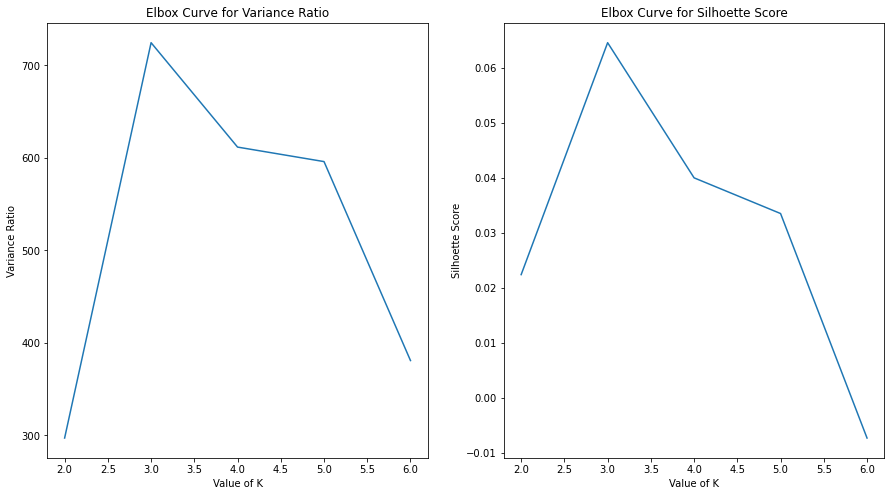

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids10.keys()],[i['v_ratio'] for i in results_kmedoids10.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids10.keys()],[i['s_score'] for i in results_kmedoids10.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [ ]:
# save results for later and use in analysis notebook
results_all['model10'] = results_kmedoids10

# Conclusions #

After running 30+ different models (by changing the random seed after each run) the results were never good. The variance ratio stayed very low and the silhoette score was very close to 0 each time. Perhaps since these were already clustered based in a similar fashion  the algorithm is having trouble re-clustering them. This is strange since some tracks are still distinct enough to further cluster together. Or perhaps the data itself is insufficient to cluster tracks further than how they have already been clustered. 